In [1]:
# Install required packages
%pip install xgboost pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset
df = pd.read_csv("../data.csv")

In [4]:
# Prepare feature matrix with treatment as a feature
X = df.drop(columns=["y", "schoolid"])
X = pd.get_dummies(X, drop_first=True)
y = df["y"]

In [5]:
# Train Random Forest S-learner
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [6]:
# Train XGBoost S-learner
xgb = XGBRegressor(random_state=42, verbosity=0)
xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [7]:
# Create two copies of X: one with z=1 and one with z=0
X1 = X.copy()
X1["z"] = 1
X0 = X.copy()
X0["z"] = 0

In [8]:
# Predict counterfactuals
mu1_rf = rf.predict(X1)
mu0_rf = rf.predict(X0)
ite_rf = mu1_rf - mu0_rf
ate_rf = np.mean(ite_rf)

mu1_xgb = xgb.predict(X1)
mu0_xgb = xgb.predict(X0)
ite_xgb = mu1_xgb - mu0_xgb
ate_xgb = np.mean(ite_xgb)

print(f"ATE (S-Learner, Random Forest): {ate_rf:.4f}")
print(f"ATE (S-Learner, XGBoost): {ate_xgb:.4f}")

ATE (S-Learner, Random Forest): 0.4214
ATE (S-Learner, XGBoost): 0.4208


In [9]:
# Bootstrap CI for S-Learner
def bootstrap_ci_slearner(model, X, n_boot=1000, alpha=0.05):
    n = len(X)
    ates = []
    X1 = X.copy()
    X0 = X.copy()
    X1['z'] = 1
    X0['z'] = 0
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        mu1 = model.predict(X1.iloc[idx])
        mu0 = model.predict(X0.iloc[idx])
        ates.append(np.mean(mu1 - mu0))
    lower = np.percentile(ates, 100 * alpha / 2)
    upper = np.percentile(ates, 100 * (1 - alpha / 2))
    return lower, upper

# Example usage:
ci_s_rf = bootstrap_ci_slearner(rf, X.copy())
ci_s_xgb = bootstrap_ci_slearner(xgb, X.copy())

print(f"95% CI (S-Learner RF): [{ci_s_rf[0]:.4f}, {ci_s_rf[1]:.4f}]")
print(f"95% CI (S-Learner XGB): [{ci_s_xgb[0]:.4f}, {ci_s_xgb[1]:.4f}]")

95% CI (S-Learner RF): [0.4085, 0.4335]
95% CI (S-Learner XGB): [0.4113, 0.4307]


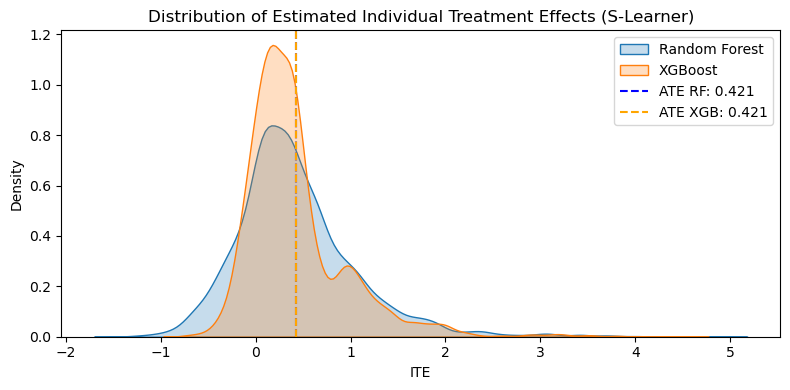

In [10]:
# Plot ITE distributions
plt.figure(figsize=(8, 4))
sns.kdeplot(ite_rf, label="Random Forest", fill=True)
sns.kdeplot(ite_xgb, label="XGBoost", fill=True)
plt.axvline(ate_rf, color="blue", linestyle="--", label=f"ATE RF: {ate_rf:.3f}")
plt.axvline(ate_xgb, color="orange", linestyle="--", label=f"ATE XGB: {ate_xgb:.3f}")
plt.title("Distribution of Estimated Individual Treatment Effects (S-Learner)")
plt.xlabel("ITE")
plt.legend()
plt.tight_layout()
plt.show()

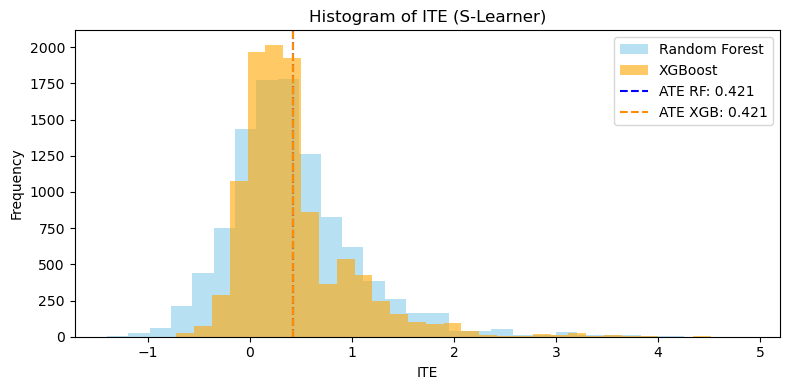

In [11]:
# Histogram of ITEs (side-by-side)
plt.figure(figsize=(8, 4))
plt.hist(ite_rf, bins=30, alpha=0.6, label='Random Forest', color='skyblue')
plt.hist(ite_xgb, bins=30, alpha=0.6, label='XGBoost', color='orange')
plt.axvline(ate_rf, color='blue', linestyle='--', label=f"ATE RF: {ate_rf:.3f}")
plt.axvline(ate_xgb, color='darkorange', linestyle='--', label=f"ATE XGB: {ate_xgb:.3f}")
plt.title("Histogram of ITE (S-Learner)")
plt.xlabel("ITE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


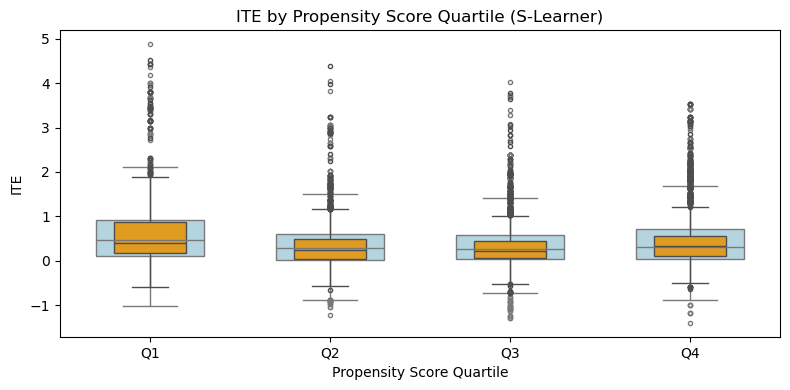

In [12]:
# Add pscore if not present
from sklearn.linear_model import LogisticRegression
X_ps = df.drop(columns=['y', 'z', 'schoolid'])
X_ps = pd.get_dummies(X_ps, drop_first=True)
t = df['z']

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_ps, t)
df['pscore'] = ps_model.predict_proba(X_ps)[:, 1]

# Add quartiles and ITEs
df['pscore_bin'] = pd.qcut(df['pscore'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
df['ite_rf'] = ite_rf
df['ite_xgb'] = ite_xgb

# Boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x="pscore_bin", y="ite_rf", data=df, color="lightblue", width=0.6, fliersize=3)
sns.boxplot(x="pscore_bin", y="ite_xgb", data=df, color="orange", width=0.4, fliersize=3)
plt.title("ITE by Propensity Score Quartile (S-Learner)")
plt.xlabel("Propensity Score Quartile")
plt.ylabel("ITE")
plt.tight_layout()
plt.show()

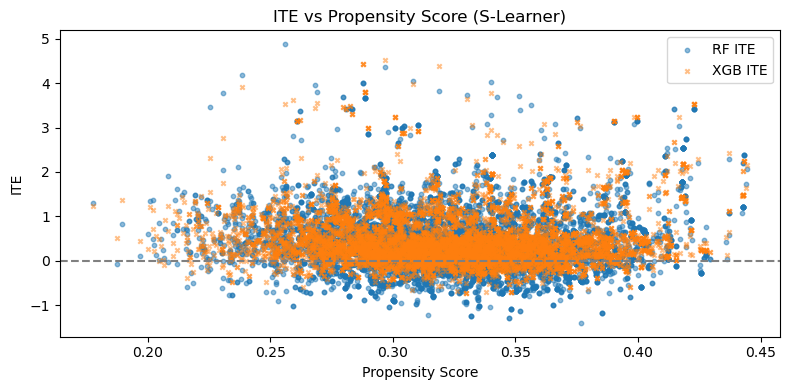

In [13]:
# Scatter: ITE vs. Propensity Score
plt.figure(figsize=(8, 4))
plt.scatter(df['pscore'], ite_rf, s=10, alpha=0.5, label='RF ITE')
plt.scatter(df['pscore'], ite_xgb, s=10, alpha=0.5, marker='x', label='XGB ITE')
plt.axhline(0, color='gray', linestyle='--')
plt.title("ITE vs Propensity Score (S-Learner)")
plt.xlabel("Propensity Score")
plt.ylabel("ITE")
plt.legend()
plt.tight_layout()
plt.show()